# WOFOST 7.2

In [1]:
%matplotlib inline
import sys
import copy
import datetime as dt
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender, STLTransformer
from sktime.forecasting.trend import PolynomialTrendForecaster
from xgboost import XGBRegressor, XGBRFRegressor 
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
from sktime.transformations.series.boxcox import BoxCoxTransformer, LogTransformer
from sktime.transformations.series.cos import CosineTransformer
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.panel.rocket import MiniRocket
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.summarize import WindowSummarizer

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

This notebook was built with:
python version: 3.10.14 (main, Jul 16 2024, 22:12:21) [GCC 9.4.0]
PCSE version: 5.5.6


# Noise-free ground truth

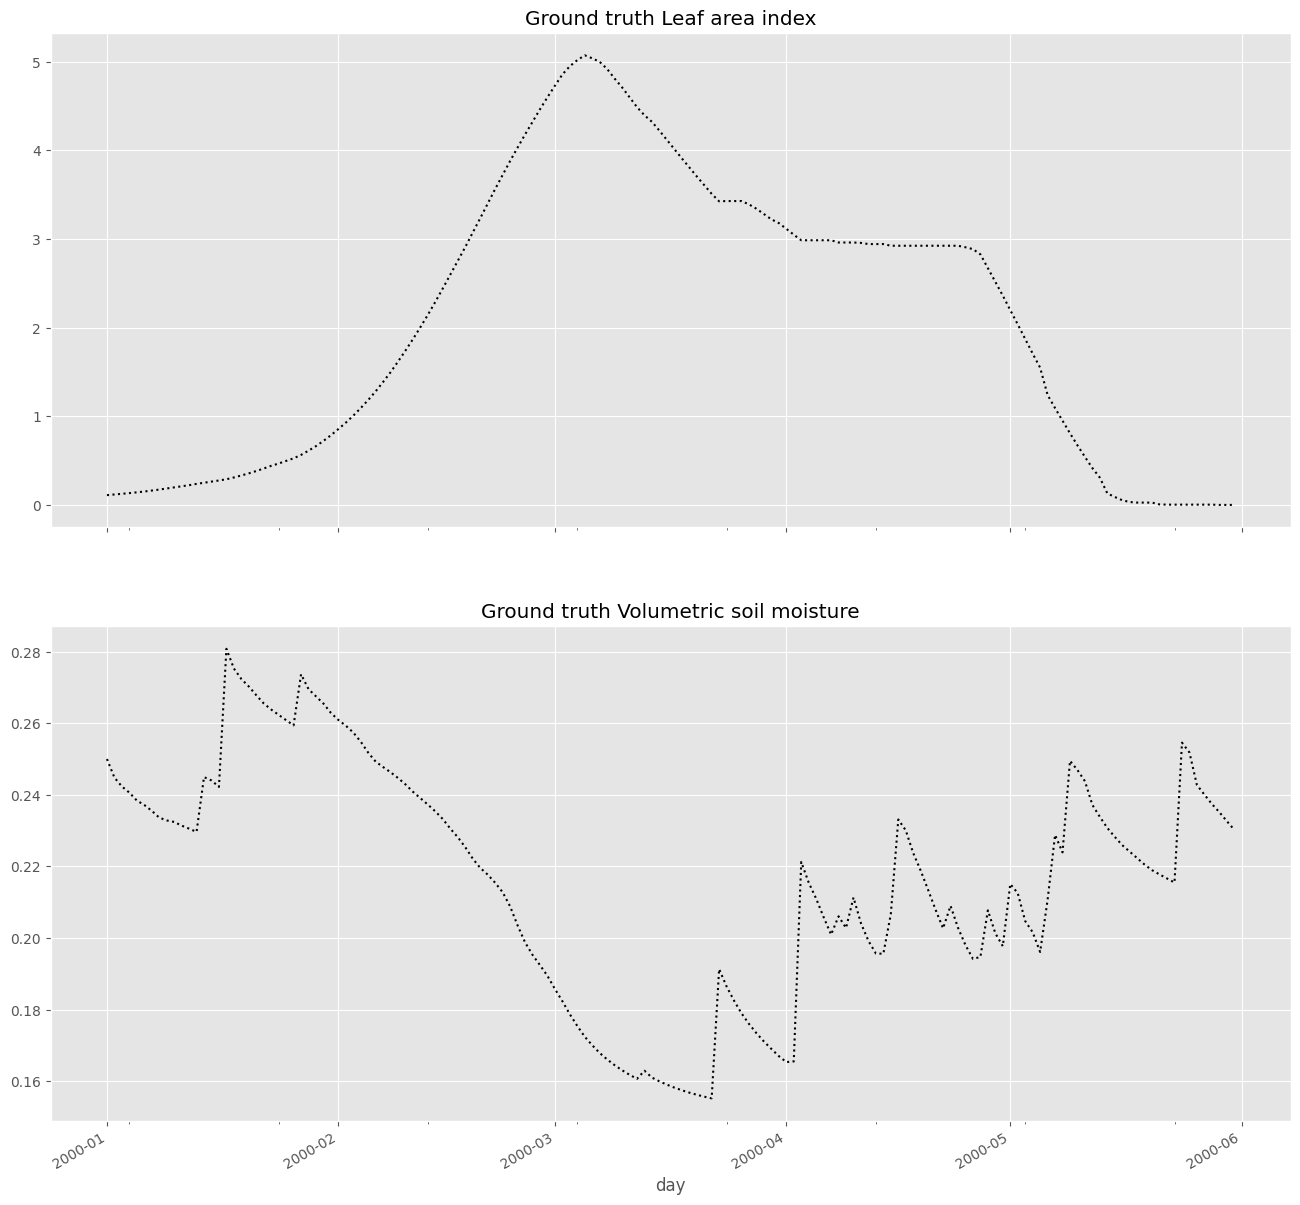

In [2]:
true_params = {}
true_params["TDWI"] = 160
true_params["WAV"] = 5
true_params["SPAN"] = 33
true_params["SMFCF"] = .33

p = copy.deepcopy(parameters)
for par, distr in true_params.items():
    p.set_override(par, distr)
ground_truth = Wofost72_WLP_FD(p, weather, agromanagement)
ground_truth.run_till_terminate()

observed_df = pd.DataFrame(ground_truth.get_output()).set_index("day")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=True)
observed_df["LAI"].plot(style="k:", ax=axes[0])
observed_df["SM"].plot(style="k:", ax=axes[1])
axes[0].set_title("Ground truth Leaf area index")
axes[1].set_title("Ground truth Volumetric soil moisture")
fig.autofmt_xdate()

# Monte Carlo simulation

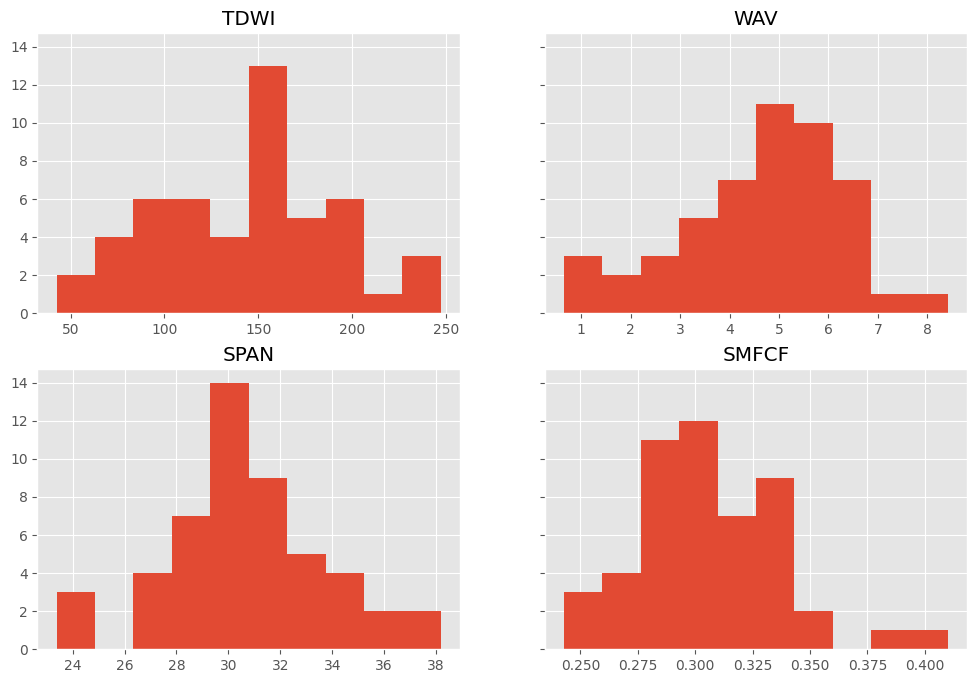

In [3]:
ensemble_size = 50
np.random.seed(10000)

# A container for the parameters that we will override
override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03 ,(ensemble_size))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

# Ensemble (without assimilation)

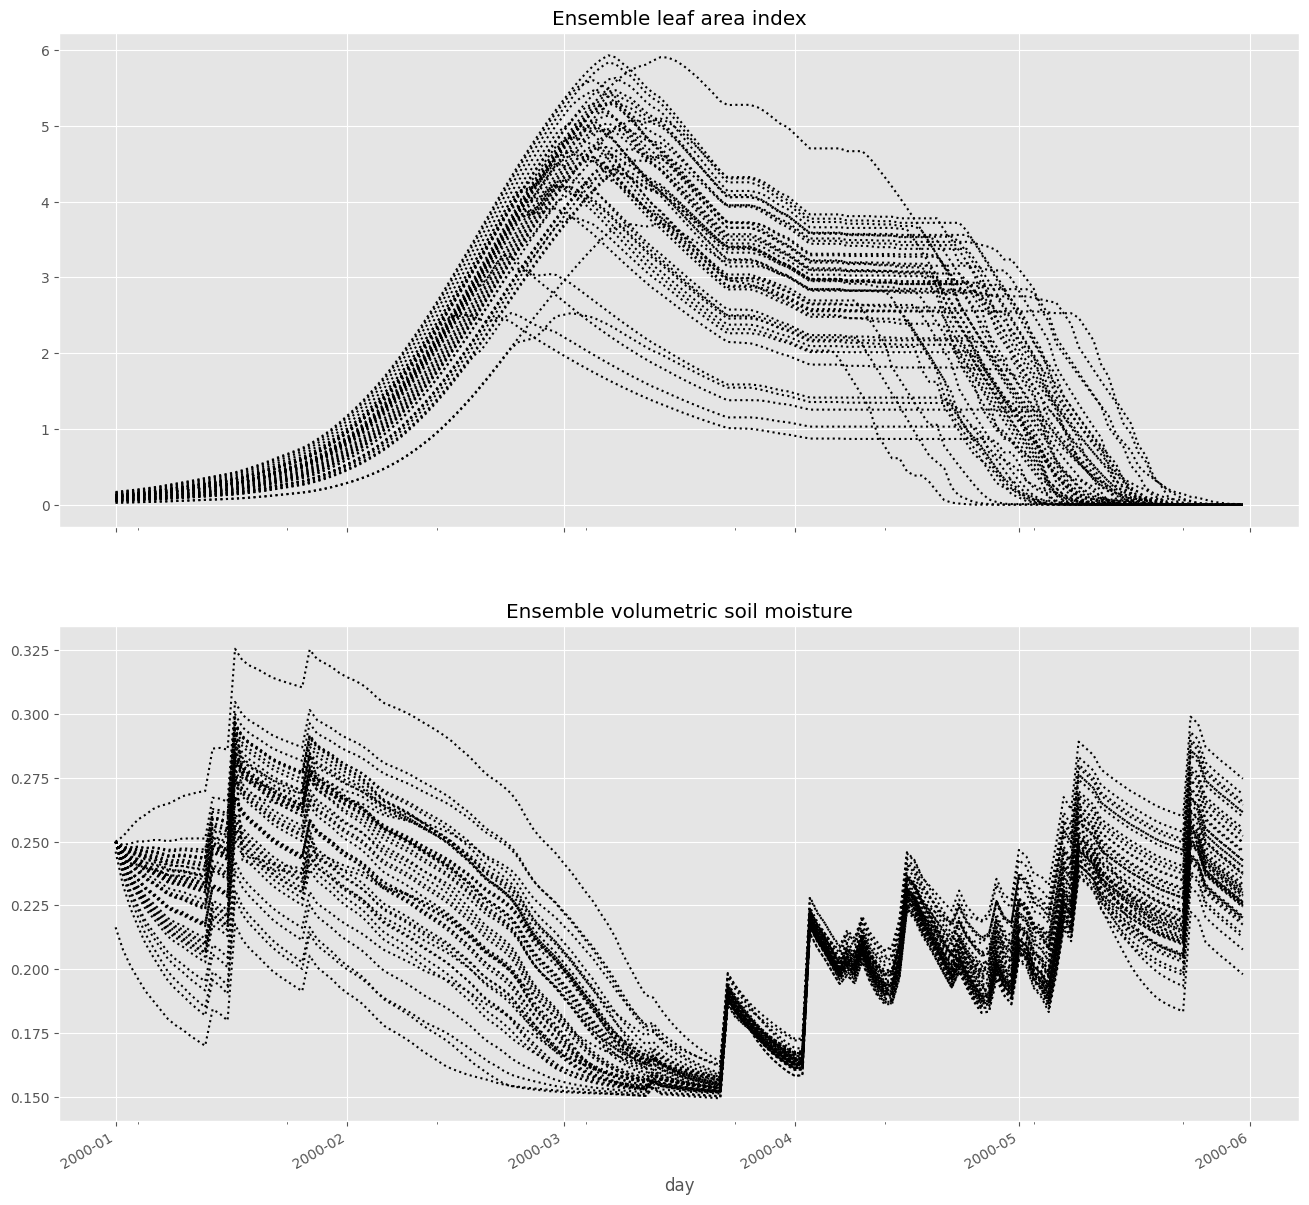

In [4]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

show_output = True
for member in ensemble:
    member.run_till_terminate()

results = [pd.DataFrame(member.get_output()).set_index("day") for member in ensemble]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=True)
for member_df in results:
    member_df["LAI"].plot(style="k:", ax=axes[0])
    member_df["SM"].plot(style="k:", ax=axes[1])
axes[0].set_title("Ensemble leaf area index")
axes[1].set_title("Ensemble volumetric soil moisture")
fig.autofmt_xdate()

# Ensemble quantiles (without assimilation)

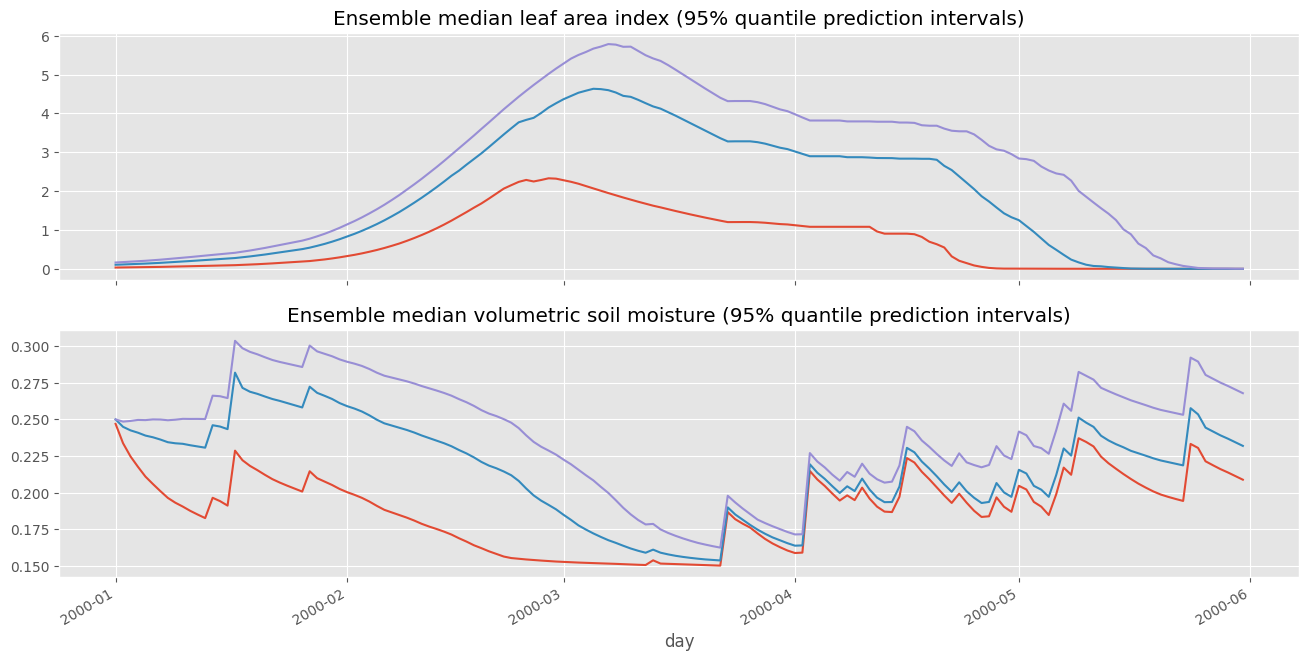

In [5]:
for i, member_df in enumerate(results):
    member_df["sim_id"] = i
    member_df["observed_LAI"] = observed_df["LAI"]
    member_df["observed_SM"] = observed_df["SM"] 
ensemble_results_df = pd.concat(results)[["sim_id", "LAI", "SM", "observed_SM"]]
ensemble_results_df

def q1(x):
    return x.quantile(0.025)

def q2(x):
    return x.quantile(0.5)
    
def q3(x):
    return x.quantile(0.975)

agg = {'LAI': [q1, q2, q3], "SM": [q1, q2, q3]}

combined_results = ensemble_results_df.groupby('day').agg(agg)
combined_results.columns = ['_'.join(col) for col in combined_results.columns]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=False)
combined_results["LAI_q1"].plot(ax=axes[0])
combined_results["LAI_q2"].plot(ax=axes[0])
combined_results["LAI_q3"].plot(ax=axes[0])
combined_results["SM_q1"].plot(ax=axes[1])
combined_results["SM_q2"].plot(ax=axes[1])
combined_results["SM_q3"].plot(ax=axes[1])
axes[0].set_title("Ensemble median leaf area index (95% quantile prediction intervals)")
axes[1].set_title("Ensemble median volumetric soil moisture (95% quantile prediction intervals)")
fig.autofmt_xdate()

# Ensemble (with assimilation)

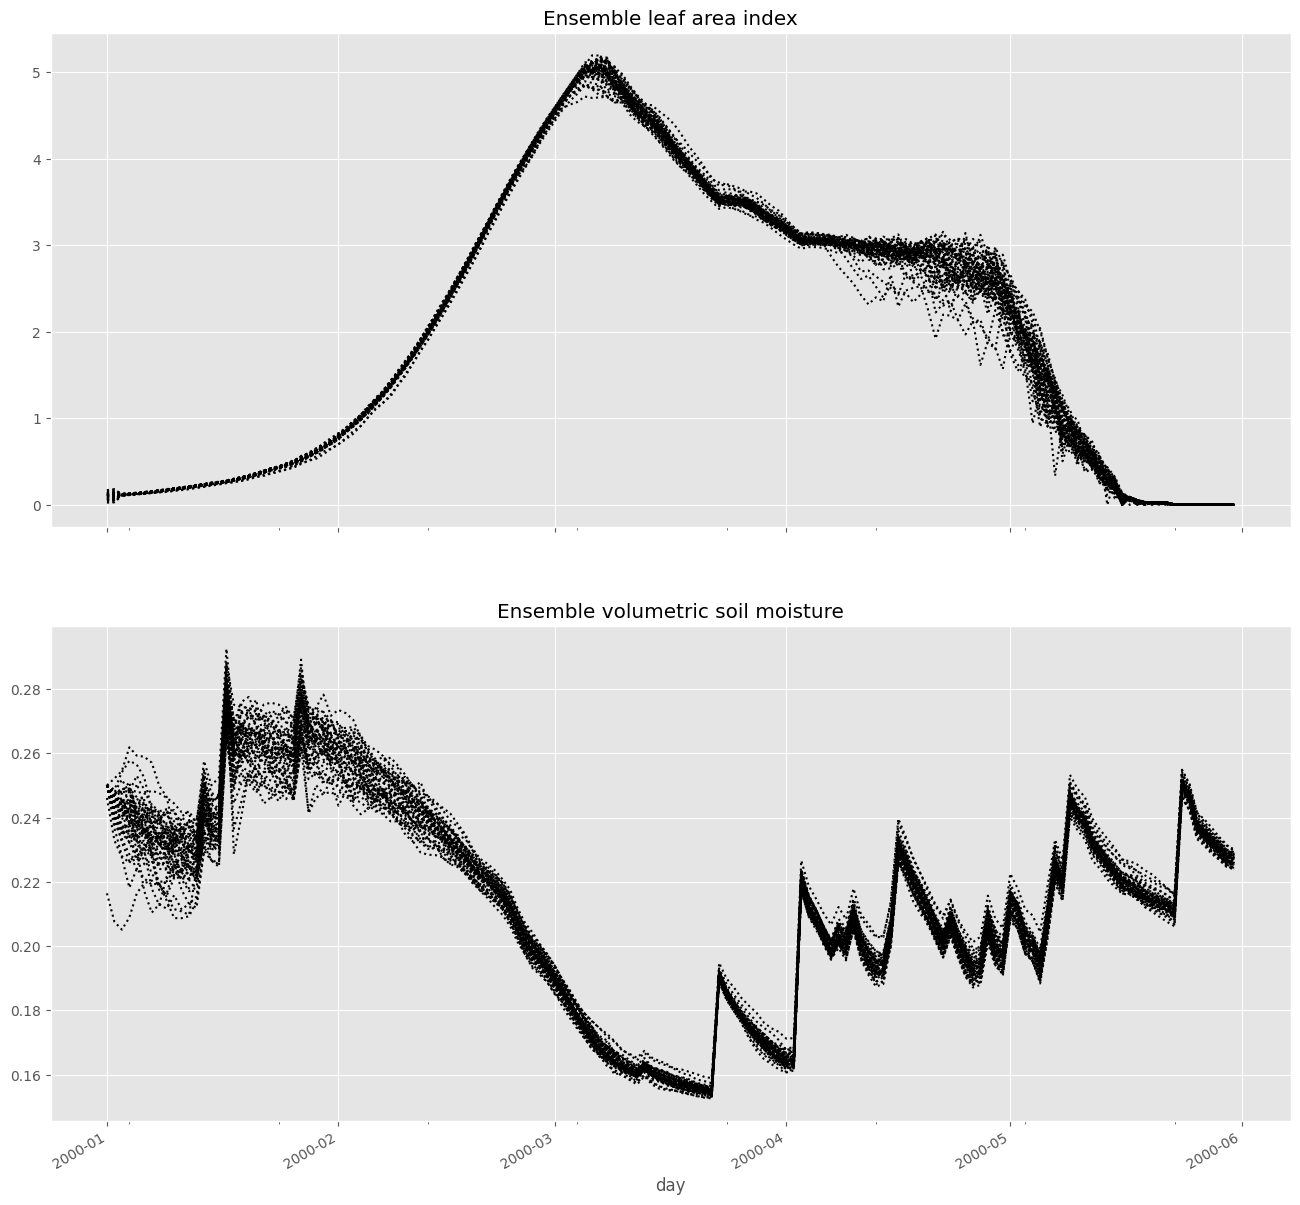

In [6]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

variables_for_DA = ["LAI", "SM"]
show_output = True
for day, row in observed_df.iterrows():
    collected_states = []
    for member in ensemble:
        member.run(1)
        t = {}
        for state in variables_for_DA:
            t[state] = member.get_variable(state)
        collected_states.append(t)
    df_A = pd.DataFrame(collected_states)
    A = np.matrix(df_A, dtype=float).T
    if np.isnan(A).any():
        continue
    P_e = np.matrix(df_A.cov())
    perturbed_obs = []
    for state in variables_for_DA:
        value = row[state]
        std = value * 0.05
        d = np.random.normal(value, std, (ensemble_size))
        perturbed_obs.append(d)
    df_perturbed_obs = pd.DataFrame(perturbed_obs).T
    df_perturbed_obs.columns = variables_for_DA
    D = np.matrix(df_perturbed_obs).T
    R_e = np.matrix(df_perturbed_obs.cov())

    H = np.identity(len(variables_for_DA))
    K1 = P_e * (H.T)
    K2 = (H * P_e) * H.T
    K = K1 * ((K2 + R_e).I)

    Aa = A + K * (D - (H * A))
    df_Aa = pd.DataFrame(Aa.T, columns=variables_for_DA)
    for member, new_states in zip(ensemble, df_Aa.itertuples()):
        r1 = member.set_variable("LAI", new_states.LAI)
        r2 = member.set_variable("SM", new_states.SM)
    
results = [pd.DataFrame(member.get_output()).set_index("day") for member in ensemble]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=True)
for member_df in results:
    member_df["LAI"].plot(style="k:", ax=axes[0])
    member_df["SM"].plot(style="k:", ax=axes[1])
axes[0].set_title("Ensemble leaf area index")
axes[1].set_title("Ensemble volumetric soil moisture")
fig.autofmt_xdate()

# Ensemble quantiles (with assimilation)

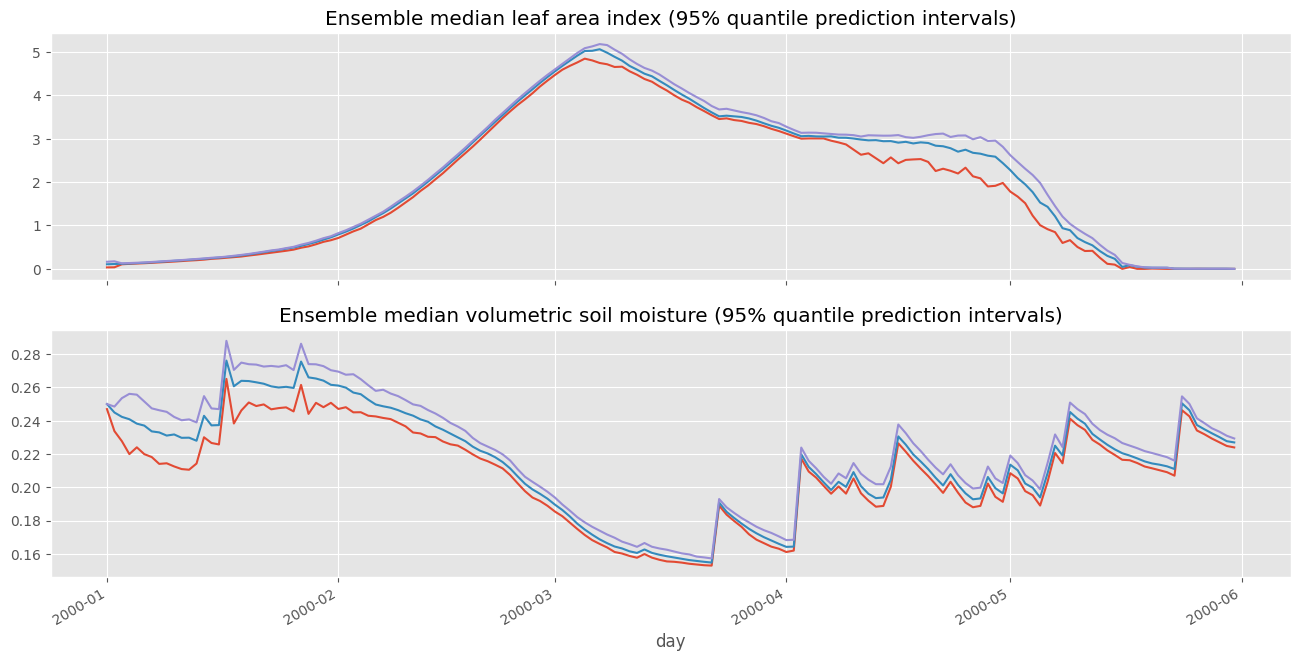

In [7]:
for i, member_df in enumerate(results):
    member_df["sim_id"] = i
    member_df["observed_LAI"] = observed_df["LAI"]
    member_df["observed_SM"] = observed_df["SM"] 
ensemble_results_df = pd.concat(results)[["sim_id", "LAI", "SM", "observed_SM"]]
ensemble_results_df

def q1(x):
    return x.quantile(0.025)

def q2(x):
    return x.quantile(0.5)
    
def q3(x):
    return x.quantile(0.975)

agg = {'LAI': [q1, q2, q3], "SM": [q1, q2, q3]}

combined_results = ensemble_results_df.groupby('day').agg(agg)
combined_results.columns = ['_'.join(col) for col in combined_results.columns]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=False)
combined_results["LAI_q1"].plot(ax=axes[0])
combined_results["LAI_q2"].plot(ax=axes[0])
combined_results["LAI_q3"].plot(ax=axes[0])
combined_results["SM_q1"].plot(ax=axes[1])
combined_results["SM_q2"].plot(ax=axes[1])
combined_results["SM_q3"].plot(ax=axes[1])
axes[0].set_title("Ensemble median leaf area index (95% quantile prediction intervals)")
axes[1].set_title("Ensemble median volumetric soil moisture (95% quantile prediction intervals)")
fig.autofmt_xdate()

# Serial Hybrid (Global/Panel forecasting)

## Data split

In [446]:
value_col = "SM"

ensemble_results_df.index = pd.to_datetime(ensemble_results_df.index)
observed_df.index = pd.to_datetime(observed_df.index)

hierarchical_df = ensemble_results_df.reset_index().set_index(["sim_id", "day"])[[value_col, f"observed_{value_col}"]]
hierarchical_df

SM  observed_SM
sim_id day                              
0      2000-01-01  0.250000     0.250000
       2000-01-02  0.240515     0.244819
       2000-01-03  0.236367     0.242331
       2000-01-04  0.237628     0.240616
       2000-01-05  0.234142     0.238408
...                     ...          ...
49     2000-05-27  0.233455     0.240065
       2000-05-28  0.230977     0.237451
       2000-05-29  0.229225     0.235169
       2000-05-30  0.227180     0.232671
       2000-05-31  0.226550     0.230250

[7600 rows x 2 columns]

In [447]:
y = pd.DataFrame(hierarchical_df[value_col])
obs = pd.DataFrame(observed_df[value_col])
y_train, y_test = temporal_train_test_split(y, test_size=0.15)  
obs_train, obs_test = temporal_train_test_split(obs, test_size=0.15)  

y_train = np.log(y_train)
y_test = np.log(y_test)

## Model fitting

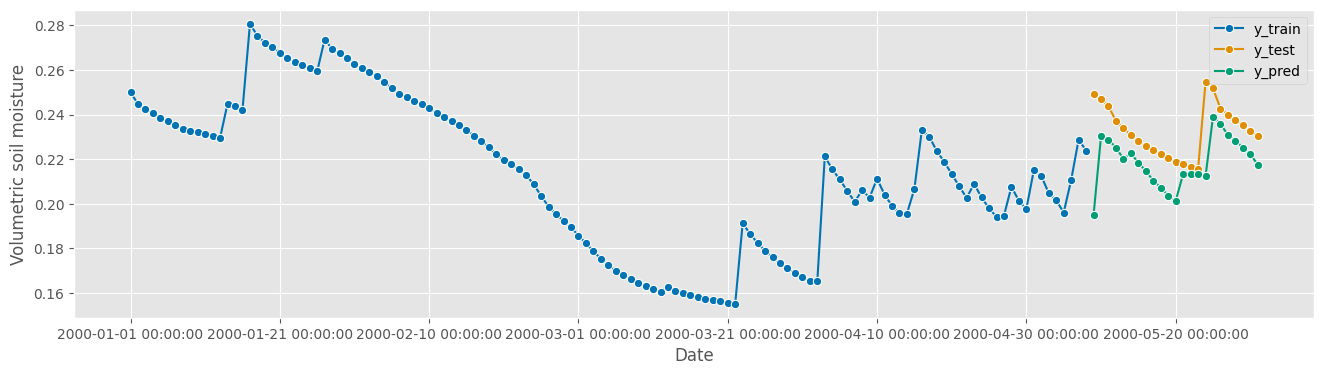

In [448]:
kwargs = {
    "lag_feature": {
        "lag": range(1, 15),
        "mean": [[1, 3], [3, 6], [6, 9], [9, 12], [12, 15], [15, 18]],
        "std": [[1, 3], [3, 6], [6, 9], [9, 12], [12, 15], [15, 18]],
    },
    "truncate": "bfill"
}

forecasters = []
for regressor in [
    KNeighborsRegressor(n_neighbors=8, n_jobs = -1),
    RadiusNeighborsRegressor(n_jobs = -1)
]:
    forecaster_name = regressor.__class__.__name__
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="additive", sp=52)),
            ("forecast", make_reduction(
                regressor, 
                transformers = [ WindowSummarizer(**kwargs, n_jobs=-1) ],
                window_length=None, 
                strategy="recursive",
                pooling="global",
            )),
        ]
    )
    forecasters.append((forecaster_name, forecaster))

forecasters.append((
    STLForecaster.__class__.__name__,
    STLForecaster(
        sp=48, 
        seasonal=25, 
        seasonal_deg=20, 
        trend_deg=20, 
        low_pass_deg=20, 
        robust=False, 
        seasonal_jump=20,
        trend_jump=20, 
        low_pass_jump=20,
    )  
))
forecaster = EnsembleForecaster(forecasters=forecasters, n_jobs = -1, aggfunc = "median")

fh = range(1, len(y_test.loc[0]) + 1)
import warnings
warnings.filterwarnings('ignore')
forecaster.fit(y=y_train, fh=fh)
y_global_pred = forecaster.predict(fh=fh) 

def aggregate_ts(ts):
    return ts.reset_index().groupby("day").median().reset_index().drop(columns = "sim_id").set_index("day")

plot_series(
    obs_train, 
    obs_test, 
    np.exp(aggregate_ts(y_global_pred)),
    labels=["y_train", "y_test", "y_pred"], 
    x_label='Date', 
    y_label='Volumetric soil moisture',
    pred_interval = None 
);


# Serial Hybrid (Exogenous covariates)

## Data split

In [449]:
pivot_df = ensemble_results_df.reset_index().pivot(index='day', columns='sim_id', values=[value_col])
pivot_df.columns = pivot_df.columns.get_level_values(1)
pivot_df["observed_SM"] = observed_df[value_col] 
pivot_df

sim_id,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,observed_SM
day,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,...,0.250000,0.250000,0.250000,0.250000,0.216435,0.250000,0.250000,0.250000,0.250000,0.250000
2000-01-02,0.240515,0.246751,0.244890,0.245105,0.245402,0.245226,0.241146,0.243885,0.244748,0.241344,...,0.247783,0.238462,0.247449,0.245574,0.207574,0.247072,0.241634,0.248687,0.244401,0.244819
2000-01-03,0.236367,0.247869,0.241778,0.244598,0.242494,0.241169,0.240534,0.240628,0.241969,0.237186,...,0.251810,0.233379,0.244831,0.245498,0.205129,0.243809,0.237390,0.254076,0.242960,0.242331
2000-01-04,0.237628,0.248049,0.242142,0.238279,0.241124,0.235252,0.240887,0.239604,0.245266,0.237075,...,0.247637,0.228562,0.245559,0.244597,0.208894,0.244986,0.234819,0.257646,0.240710,0.240616
2000-01-05,0.234142,0.240042,0.241040,0.241530,0.243083,0.236823,0.234406,0.237113,0.241669,0.232536,...,0.243139,0.223964,0.246144,0.236690,0.216477,0.244239,0.227403,0.256434,0.234198,0.238408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-05-27,0.231822,0.239396,0.233618,0.236107,0.234012,0.236267,0.233051,0.236129,0.237634,0.238804,...,0.233820,0.233192,0.237670,0.237434,0.233563,0.235714,0.234939,0.234761,0.233455,0.240065
2000-05-28,0.229249,0.236808,0.231389,0.234027,0.231570,0.233901,0.230934,0.233748,0.235527,0.235280,...,0.231401,0.231056,0.235084,0.234647,0.230821,0.233037,0.232447,0.232590,0.230977,0.237451
2000-05-29,0.226867,0.233907,0.228717,0.231999,0.229216,0.231615,0.228459,0.231563,0.233517,0.233112,...,0.229322,0.229204,0.232660,0.232279,0.228842,0.230549,0.229313,0.230273,0.229225,0.235169


In [450]:
predictor_cols = list(range(ensemble_size))
pivot_df.index = pd.to_datetime(pivot_df.index)
pivot_df.index = pd.DatetimeIndex(pivot_df.index, freq="D")

dt_transformer = DateTimeFeatures(ts_freq="D")
X = pivot_df[predictor_cols]
X = X.join(dt_transformer.fit_transform(X))

y = pivot_df["observed_SM"]
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.15)  

## Model fitting

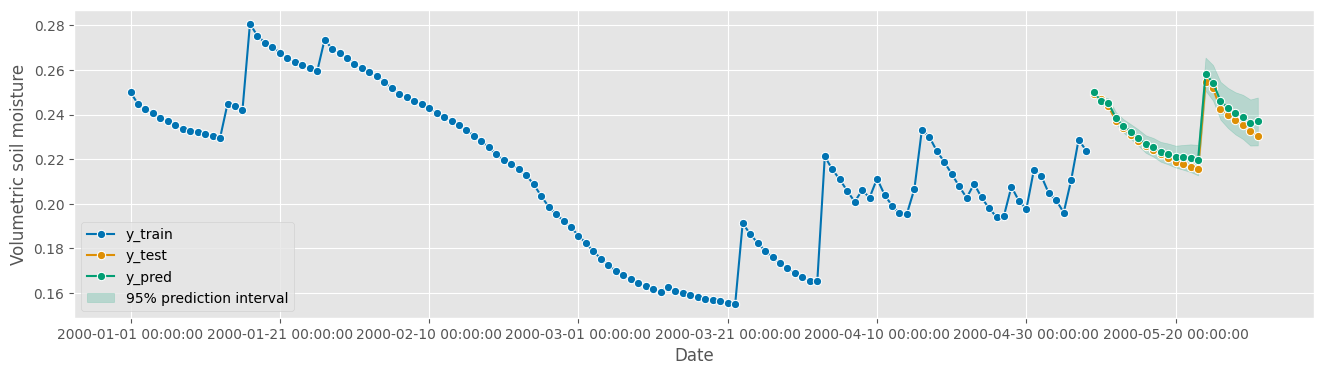

In [451]:
from sktime.forecasting.sarimax import SARIMAX

fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = SARIMAX(
    order=(1, 1, 1), trend="t", seasonal_order=(6, 1, 6, 12)
)
forecaster.fit(y=y_train, X=X_train, fh=fh)
pred_interval = forecaster.predict_interval(X=X_test, fh=fh, coverage=0.95)
y_pred = forecaster.predict(fh=fh, X=X_test) 

plot_series(
    y_train, 
    y_test, 
    y_pred,
    labels=["y_train", "y_test", "y_pred"], 
    x_label='Date', 
    y_label='Volumetric soil moisture',
    pred_interval = pred_interval 
);

# Serial Hybrid (Global/Panel forecasting -> Exogenous covariates)

## Data split

In [452]:
y_pivot = y_global_pred.reset_index().pivot(index='day', columns='sim_id', values=[value_col]) 
y_pivot.columns = y_pivot.columns.get_level_values(1)
y_pivot = np.exp(y_pivot)
y_pivot = y_pivot.join(dt_transformer.fit_transform(y_pivot))
y_pivot

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,year,month_of_year,day_of_week
day,,,,,,,,,,,,,,,,,,,,,
2000-05-09,0.193319,0.196171,0.195643,0.188403,0.198299,0.196654,0.191330,0.192743,0.202822,0.199007,...,0.199796,0.194118,0.199978,0.200438,0.198141,0.194516,0.192106,2000,5,1
2000-05-10,0.225471,0.236613,0.229650,0.221302,0.242724,0.225815,0.224667,0.225167,0.243132,0.243769,...,0.243819,0.225590,0.232252,0.240937,0.230378,0.226841,0.224737,2000,5,2
2000-05-11,0.223072,0.229228,0.229655,0.216593,0.234611,0.227409,0.223359,0.226009,0.239561,0.235516,...,0.236425,0.223987,0.226995,0.235836,0.230494,0.226387,0.225006,2000,5,3
2000-05-12,0.224061,0.226648,0.226479,0.218445,0.228871,0.226985,0.221017,0.223155,0.235100,0.229479,...,0.230978,0.223592,0.231061,0.231577,0.228106,0.224969,0.222236,2000,5,4
2000-05-13,0.218728,0.221174,0.221467,0.213747,0.223715,0.222017,0.216067,0.218044,0.229906,0.224316,...,0.225955,0.218412,0.225621,0.226350,0.222656,0.219143,0.216753,2000,5,5
2000-05-14,0.222211,0.223846,0.223857,0.216654,0.225010,0.223715,0.217718,0.221180,0.225752,0.226895,...,0.223112,0.220565,0.227073,0.225231,0.223655,0.219879,0.222262,2000,5,6
2000-05-15,0.218418,0.219226,0.218688,0.213090,0.220609,0.219898,0.214545,0.219121,0.225054,0.222647,...,0.220034,0.217873,0.221520,0.220159,0.219843,0.216738,0.217258,2000,5,0
2000-05-16,0.214663,0.215186,0.215000,0.211954,0.216739,0.215038,0.211595,0.215945,0.221913,0.218062,...,0.216658,0.214727,0.214843,0.218457,0.213818,0.213318,0.214359,2000,5,1
2000-05-17,0.210214,0.211270,0.210552,0.206501,0.211988,0.211266,0.208363,0.212197,0.218419,0.215213,...,0.215337,0.212143,0.210861,0.214894,0.209911,0.210459,0.210408,2000,5,2


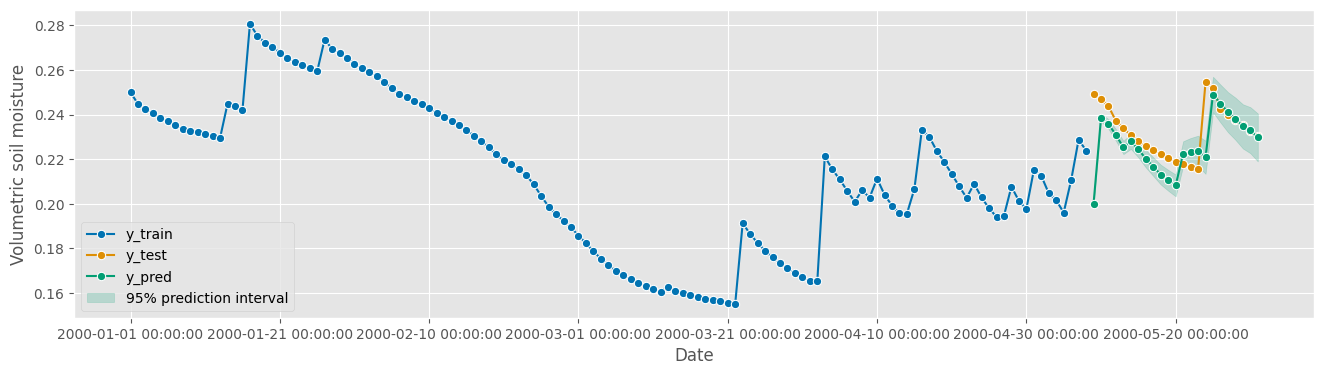

In [453]:
pred_interval = forecaster.predict_interval(X=y_pivot, fh=fh, coverage=0.95)
y_pred = forecaster.predict(fh=fh, X=y_pivot) 

plot_series(
    y_train, 
    y_test, 
    y_pred,
    labels=["y_train", "y_test", "y_pred"], 
    x_label='Date', 
    y_label='Volumetric soil moisture',
    pred_interval = pred_interval 
);